In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np


import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Some weights of .* were not initialized from the model checkpoint")
warnings.filterwarnings("ignore", message="You should probably TRAIN this model on a down-stream task")

# Your code here
# Example:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Reset the warnings to default behavior after executing the code
warnings.resetwarnings()

2024-04-29 09:24:37.947399: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def run_experiment(layer_name, layers_to_skip, num_samples, dataset_path="customer_support_tickets.csv"):
    print(f"\nRunning experiment: {layer_name}")
    
    # Load the dataset
    print("Loading dataset...")
    data = pd.read_csv(dataset_path)
    data = data.dropna(subset=['Ticket Description'])
    data = data[['Ticket Description', 'Ticket Type']]
    
    # Sample data if not using the full dataset
    if num_samples == "full":
        data_subset = data
    else:
        data_subset = data.sample(n=num_samples, random_state=42)
    
    # Split the data into train and test sets
    print("Splitting data into train and test sets...")
    train_texts, test_texts, train_labels, test_labels = train_test_split(data_subset['Ticket Description'], data_subset['Ticket Type'], test_size=0.2, random_state=42)
    
    # Encode labels
    print("Encoding labels...")
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    # Tokenization
    print("Tokenizing data...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

    # Convert encodings to a format suitable for the trainer
    print("Converting encodings to PyTorch Dataset format...")
    class MyDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = MyDataset(train_encodings, train_labels_encoded)
    eval_dataset = MyDataset(test_encodings, test_labels_encoded)

    # Define BERT model
    print("Loading BERT model...")
    model_finetuned = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

    # Fine-tune by skipping intermediate layers
    if layers_to_skip == 'full':
        print("Not skipping any layers (training with all layers)...")
        model_pretrained = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
    else:    
        print("Skipping specified layers...")
        encoder_layers = model_finetuned.bert.encoder.layer
        model_finetuned.bert.encoder.layer = torch.nn.ModuleList([layer for i, layer in enumerate(encoder_layers) if i in layers_to_skip])

        
    # Define training arguments
    print("Defining training arguments...")
    training_args = TrainingArguments(
        output_dir='./results_finetuned',
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        evaluation_strategy='epoch',
        logging_dir='./logs_finetuned',
        num_train_epochs=3,
        learning_rate=2e-5,
        save_strategy='epoch',
        load_best_model_at_end=True
    )

    # Define trainer
    print("Initializing trainer...")
    trainer = Trainer(
        model=model_finetuned,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    # Train and evaluate model
    print("Training and evaluating model...")
    start_time = time.time()
    trainer.train()
    preds = trainer.predict(eval_dataset)
    processing_time = time.time() - start_time

    # Calculate metrics
    print("Calculating metrics...")
    accuracy = accuracy_score(test_labels_encoded, preds.predictions.argmax(axis=1))
    precision = precision_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')
    recall = recall_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')
    f1 = f1_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')

    # Print results
    print("Results for Layer:", layer_name)
    results_df = pd.DataFrame({'Layer Name': [layer_name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1], 'Processing Time': [processing_time]})
    display(results_df)

    return results_df


In [3]:
# Example usage:
layers_to_skip = [
    np.random.choice(range(12), 6, replace=False),  # Random skipping
    [i for i in range(1, 12, 2)],  # Skipping odd layers
    [i for i in range(0, 12, 2)],  # Skipping even layers
    [0, 2, 4, 6, 8, 10],  # Skipping even-indexed layers
    [1, 3, 5, 7, 9, 11],  # Skipping odd-indexed layers
    []  # No skipping (full pre-trained)
]
num_samples = 50  # Specify the number of samples, or "full" for the full dataset
results_dfs = []

# Run experiments for each configuration
for layers in layers_to_skip:
    if len(layers) == 0:
        name = "Full_Pretrained"
        layers = 'full'
    else:
        name = "Layer_" + "_".join(str(layer) for layer in layers) + "_Skipped"
    results_df = run_experiment(name, layers, num_samples)
    results_dfs.append(results_df)

# Combine results into a single DataFrame
combined_results = pd.concat(results_dfs, ignore_index=True)
print("\nCombined Results:")
display(combined_results)


Running experiment: Layer_2_0_6_11_1_4_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1449/2538888063.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers_to_skip == 'full':
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.692601
2,No log,1.707312
3,No log,1.709884


Checkpoint destination directory ./results_finetuned/checkpoint-5 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-10 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-15 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_2_0_6_11_1_4_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_2_0_6_11_1_4_Skipped,0.2,0.0625,0.2,0.088889,43.580048



Running experiment: Layer_1_3_5_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.635312
2,No log,1.651546
3,No log,1.656912


Checkpoint destination directory ./results_finetuned/checkpoint-5 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-10 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-15 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_1_3_5_7_9_11_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_1_3_5_7_9_11_Skipped,0.2,0.04,0.2,0.066667,40.704214



Running experiment: Layer_0_2_4_6_8_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.682820
2,No log,1.680646
3,No log,1.684602


Checkpoint destination directory ./results_finetuned/checkpoint-5 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-10 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-15 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_0_2_4_6_8_10_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_0_2_4_6_8_10_Skipped,0.2,0.04,0.2,0.066667,40.295992



Running experiment: Layer_0_2_4_6_8_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.682820
2,No log,1.680646
3,No log,1.684602


Checkpoint destination directory ./results_finetuned/checkpoint-5 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-10 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-15 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_0_2_4_6_8_10_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_0_2_4_6_8_10_Skipped,0.2,0.04,0.2,0.066667,40.544293



Running experiment: Layer_1_3_5_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.635312
2,No log,1.651546
3,No log,1.656912


Checkpoint destination directory ./results_finetuned/checkpoint-5 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-10 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-15 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_1_3_5_7_9_11_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_1_3_5_7_9_11_Skipped,0.2,0.04,0.2,0.066667,40.630307



Running experiment: Full_Pretrained
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Not skipping any layers (training with all layers)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,No log,1.693979
2,No log,1.714190
3,No log,1.723999


Checkpoint destination directory ./results_finetuned/checkpoint-5 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-10 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-15 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Full_Pretrained


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Full_Pretrained,0.2,0.044444,0.2,0.072727,76.85467



Combined Results:


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_2_0_6_11_1_4_Skipped,0.2,0.062500,0.2,0.088889,43.580048
1,Layer_1_3_5_7_9_11_Skipped,0.2,0.040000,0.2,0.066667,40.704214
2,Layer_0_2_4_6_8_10_Skipped,0.2,0.040000,0.2,0.066667,40.295992
3,Layer_0_2_4_6_8_10_Skipped,0.2,0.040000,0.2,0.066667,40.544293
4,Layer_1_3_5_7_9_11_Skipped,0.2,0.040000,0.2,0.066667,40.630307
5,Full_Pretrained,0.2,0.044444,0.2,0.072727,76.854670


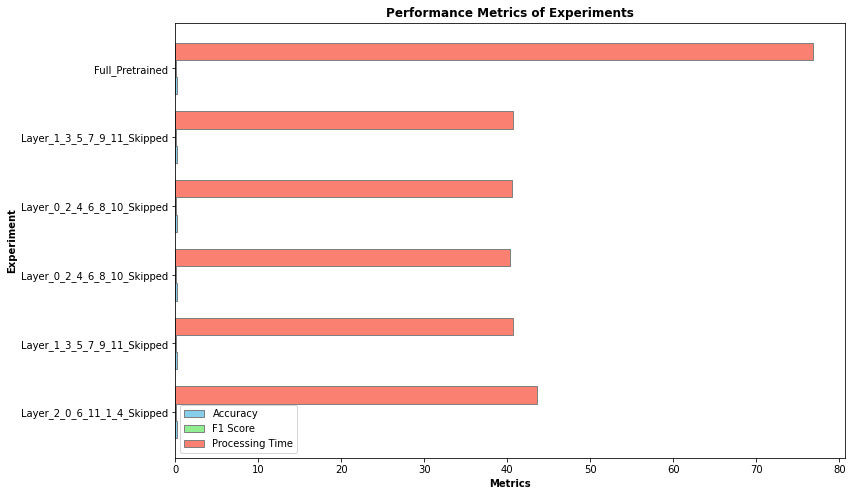

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the relevant data from the combined results DataFrame
experiment_names = combined_results['Layer Name']
accuracy = combined_results['Accuracy']
f1_score = combined_results['F1']
processing_time = combined_results['Processing Time']

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(experiment_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the results
plt.figure(figsize=(12, 8))

plt.barh(r1, accuracy, color='skyblue', height=bar_width, edgecolor='grey', label='Accuracy')
plt.barh(r2, f1_score, color='lightgreen', height=bar_width, edgecolor='grey', label='F1 Score')
plt.barh(r3, processing_time, color='salmon', height=bar_width, edgecolor='grey', label='Processing Time')

# Add labels, tick labels, and title
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Experiment', fontweight='bold')
plt.yticks([r + bar_width for r in range(len(experiment_names))], experiment_names)
plt.title('Performance Metrics of Experiments', fontweight='bold')
plt.legend()

plt.show()
